In [1]:
import os
import sys
from pathlib import Path
import numpy as np
from scipy.ndimage import zoom

repo_root = Path.cwd().parent
sys.path.append(str(repo_root))

#folder_name = os.path.join(r'\\10.229.121.108','Workspace','PAT LINEAR','PATDOTUS','01')
folder_name = os.path.join(r'\\10.229.121.108','Workspace','PAT LINEAR','20240703 PAT TEST','Lukai','sni060_z1_scan1')

from src.load_data_utils import list_subfolders, linear_pa_param
from src.pat_utils import pa_das_linear, apply_tgc, pa_inverse_recon
import matplotlib.pyplot as plt

all_folders = list_subfolders(folder_name)
print(f"Found {len(all_folders)} image folders")
info = linear_pa_param()

Found 16 image folders


In [ ]:
input_dir = all_folders[9]
apod_method = 'hann'
coherence_method = 'cf'
Z_display = 4e-2
RF_Sum, RF_env_raw = pa_das_linear(input_dir, info, apod_method, coherence_method)

In [ ]:
# Dynamic Ranging
dB_PA = 45
min_dB = 10 ** (-dB_PA / 20.0)
#RF_tgc = apply_tgc(RF_env_raw, info, alpha=20.0)
RF_tgc = RF_env_raw  # without TGC
RF_env_norm = RF_tgc / np.max(RF_tgc) if np.max(RF_tgc) != 0 else RF_tgc
# RF_log = (20/dB_US)*log10(RF_env_norm)+1
with np.errstate(divide='ignore', invalid='ignore'):
    RF_log = (20.0 / dB_PA) * np.log10(np.maximum(RF_env_norm, 1e-20)) + 1.0
RF_log[RF_env_norm < min_dB] = 0.0
    
# Compute target image size
z_range = np.max(info.d_sample)
xz_ratio = info.FOV / z_range
Lx = int(4 * info.N_sc * 2.0/3.0)
Lz = int(round(4 * info.N_sc / xz_ratio)) if xz_ratio != 0 else RF_log.shape[0]
# Use scipy.ndimage.zoom to resize to (Lz, Lx)
zoom_z = Lz / RF_log.shape[0] if RF_log.shape[0] > 0 else 1.0
zoom_x = Lx / RF_log.shape[1] if RF_log.shape[1] > 0 else 1.0
RF_log_resized = zoom(RF_log, (zoom_z, zoom_x), order=1)
print(RF_log_resized.shape)
idx_z = int(Z_display / z_range * RF_log_resized.shape[0])
print(f"Display at z={Z_display*1e3:.1f} mm, index {idx_z} of {RF_log_resized.shape[0]}")
plt.imshow(RF_log_resized[0:idx_z,:], cmap='hot', vmin=0.0, vmax=1.0, origin='upper', extent=[-info.FOV*50.0, info.FOV*50.0, Z_display*100, 0])
plt.show()

In [2]:
input_dir = all_folders[9]
bbox_cm_whole = (-0.8, 0.8, 1.0, 2.75)
scaling_factor = (3, 3)
mua_raw , _ = pa_inverse_recon(input_dir, info, bbox_cm_whole , scaling_factor, solver_method = 'l1', verbose=True)

'''
Z_increment = 0.25
xmin, xmax, zmin, zmax = bbox_cm_whole
L_strips = int((zmax - zmin) / Z_increment)
mua_raw = None
for i in range(L_strips):
    z_start = zmin + i * Z_increment
    z_end = z_start + Z_increment
    bbox_cm_1 = (xmin, xmax, z_start, z_end)
    print(f"Reconstructing strip {i+1}/{L_strips}, z = {z_start:.2f} to {z_end:.2f} cm")
    mua_raw1 , _ = pa_inverse_recon(input_dir, info, bbox_cm_1 , scaling_factor, solver_method = 'l2', verbose=True)
    if i == 0:
        mua_raw = mua_raw1
    else:
        mua_raw = np.concatenate((mua_raw, mua_raw1), axis=0)
'''

Imaging grid: x from -0.8 cm to 0.8 cm with dx=0.03 cm (57 points)
              z from 1.0 cm to 2.8 cm with dz=0.03 cm (62 points)
Time axis: 1093 points, from 0.00 us to 27.30 us
System matrix generated. G has shape (139904, 3534) (dtype=float32)
System matrix generated.
Imaging grid shape: Z 62, X 57
System matrix normalized.
Raw PA data loaded and preprocessed.
Starting reconstruction...
ADMM iter   1: obj=9.310218e+04, prim_res=7.792e+01, dual_res=7.939e+01, eps_primal=1.172e-01, eps_dual=8.387e-02
ADMM iter   2: obj=9.423827e+04, prim_res=2.595e+01, dual_res=5.468e+01, eps_primal=1.421e-01, eps_dual=1.089e-01
ADMM iter   3: obj=9.492953e+04, prim_res=8.536e+00, dual_res=3.412e+01, eps_primal=1.733e-01, eps_dual=1.135e-01
ADMM iter   4: obj=9.513776e+04, prim_res=6.233e+00, dual_res=2.010e+01, eps_primal=1.925e-01, eps_dual=1.115e-01
ADMM iter   5: obj=9.511682e+04, prim_res=5.388e+00, dual_res=1.157e+01, eps_primal=2.030e-01, eps_dual=1.082e-01
ADMM iter   6: obj=9.502461e+04, p

'\nZ_increment = 0.25\nxmin, xmax, zmin, zmax = bbox_cm_whole\nL_strips = int((zmax - zmin) / Z_increment)\nmua_raw = None\nfor i in range(L_strips):\n    z_start = zmin + i * Z_increment\n    z_end = z_start + Z_increment\n    bbox_cm_1 = (xmin, xmax, z_start, z_end)\n    print(f"Reconstructing strip {i+1}/{L_strips}, z = {z_start:.2f} to {z_end:.2f} cm")\n    mua_raw1 , _ = pa_inverse_recon(input_dir, info, bbox_cm_1 , scaling_factor, solver_method = \'l2\', verbose=True)\n    if i == 0:\n        mua_raw = mua_raw1\n    else:\n        mua_raw = np.concatenate((mua_raw, mua_raw1), axis=0)\n'

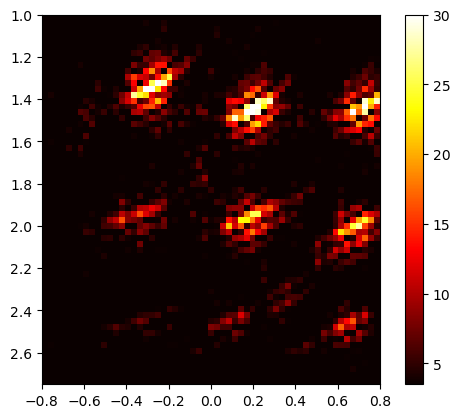

In [5]:
xmin, xmax, zmin, zmax = bbox_cm_whole
plt.imshow(mua_raw, cmap='hot', extent=[xmin, xmax, zmax, zmin], 
vmin=3.5, vmax=30)
plt.colorbar()
plt.show()

In [ ]:
Nt = meta['t'].size  # number of time samples per element
Nz, Nx = meta['Z'].shape
spatial_index = 100

iz = spatial_index // Nx
ix = spatial_index % Nx
x = meta['X'][iz, ix]
z = meta['Z'][iz, ix]
print(f"Voxel index {spatial_index} at (x,z)=({x*100:.1f} cm, {z*100:.1f} cm)")

t_tilde = np.sqrt(x ** 2 + z ** 2) / info.c
print(f"Theoretical arrival time {t_tilde*1e6:.2f} us")

In [ ]:
g_test = G[: , spatial_index].reshape(int(info.N_ele), -1).T
sir_max, sir_min = g_test.max(), g_test.min()
sir_max = np.max(np.abs([sir_max, sir_min]))
plt.figure(figsize=(8,6))
for ie in range(128):
    plt.plot(np.arange(Nt)/info.fs*1e6, g_test[:,ie] + ie*sir_max)  # offset for visualization
plt.xlabel('Time [µs]')
plt.ylabel('Element # (offset for clarity)')
plt.title('Element responses for a single voxel')
plt.show()

In [ ]:
element_idx = 68  # for example
# Extract G rows corresponding to the element
rows = slice(element_idx*Nt, (element_idx+1)*Nt)  # time indices for this element
G_element = G[rows, :]  # shape (Nt, Nvox)
sensitivity_map = np.sum(np.abs(G_element), axis=0)  # shape (Nvox,)
sensitivity_map = sensitivity_map.reshape(Nz, Nx) 
x_min, x_max, z_min, z_max = bbox_cm
plt.figure(figsize=(6,5))
plt.imshow(sensitivity_map, origin='lower', extent=[x_min, x_max, z_min, z_max],
           aspect='auto', cmap='viridis')
plt.colorbar(label='Sensitivity (a.u.)')
plt.xlabel('x [cm]')
plt.ylabel('z [cm]')
plt.title(f'Spatial Sensitivity Map: Element {element_idx}')
plt.show()